In [4]:
%matplotlib inline

# Beat tracking example
from __future__ import print_function
import numpy as np, scipy, matplotlib.pyplot as plt, librosa
from IPython.display import Audio

# 1. Get the file path to the included audio example
filename = librosa.util.example_audio_file()
print(filename)
filename = '/home/py/projects/dataset/beatles/mp3s-32k/Abbey_Road/01-Come_Together.mp3'
print(filename)


/usr/local/lib/python3.5/dist-packages/librosa/util/example_data/Kevin_MacLeod_-_Vibe_Ace.ogg
/home/py/projects/dataset/beatles/mp3s-32k/Abbey_Road/01-Come_Together.mp3


In [15]:
# Load the example clip
# y, sr = librosa.load(librosa.util.example_audio_file())
y, sr = librosa.load(filename)


In [6]:
# Separate harmonics and percussives into two waveforms
y_harmonic, y_percussive = librosa.effects.hpss(y)

/usr/local/lib/python3.5/dist-packages/librosa/util/utils.py:1478: RuntimeWarning: invalid value encountered in true_divide
  mask /= mask + (X_ref / Z)**power


In [16]:
print (y[:100])
# Audio(y, rate=sr)

[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]


In [3]:
Audio(y_harmonic, rate=sr)

In [4]:
Audio(y_percussive, rate=sr)

In [5]:
# Beat track on the percussive signal
tempo, beat_frames = librosa.beat.beat_track(y=y_percussive, sr=sr)

In [27]:
print('Estimated tempo: {:.2f} beats per minute'.format(tempo))
print(beat_frames.shape)

Estimated tempo: 103.36 beats per minute
(98,)


In [26]:
# 4. Convert the frame indices of beat events into timestamps
beat_times = librosa.frames_to_time(beat_frames, sr=sr)
print(beat_times.shape)

(98,)


In [8]:
# Compute MFCC features from the raw signal
hop_length = 512
mfcc = librosa.feature.mfcc(y=y, sr=sr, hop_length=hop_length, n_mfcc=13)

In [9]:
# And the first-order differences (delta features)
mfcc_delta = librosa.feature.delta(mfcc)

In [10]:
# Stack and synchronize between beat events
# This time, we'll use the mean value (default) instead of median
beat_mfcc_delta = librosa.feature.sync(np.vstack([mfcc, mfcc_delta]), beat_frames)

In [11]:
# Compute chroma features from the harmonic signal
chromagram = librosa.feature.chroma_cqt(y=y_harmonic, sr=sr)

/usr/local/lib/python3.5/dist-packages/numpy/core/numeric.py:482: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  return array(a, dtype, copy=False, order=order)


In [36]:
# Aggregate chroma features between beat events
# We'll use the median value of each feature between beat frames
beat_chroma = librosa.feature.sync(chromagram, beat_frames, aggregate=np.median)
print(beat_chroma[:,0])

[ 0.33127879  0.32052223  0.54493641  0.8062083   1.          0.78180973
  0.45697726  0.319838    0.15883629  0.07013554  0.19406526  0.25491138]


In [29]:
# Finally, stack all beat-synchronous features together
beat_features = np.vstack([beat_chroma, beat_mfcc_delta])
print(beat_features)

[[ 0.33127879  0.15202843  0.15639863 ...,  0.10214773  0.26491543
   0.21935423]
 [ 0.32052223  0.09606238  0.11602891 ...,  0.07603482  0.13665433
   0.25488328]
 [ 0.54493641  0.14073481  0.16223771 ...,  0.05171165  0.0649659
   0.19147755]
 ..., 
 [ 0.90547042 -0.3637608  -0.10544266 ..., -0.32315918  0.00432262
   0.09078772]
 [ 0.84605864 -0.37301524 -0.15888862 ...,  0.10774945 -0.33715566
   0.01820109]
 [ 1.13507909 -0.36041291 -0.20593333 ...,  0.06679567 -0.05400572
  -0.02260783]]


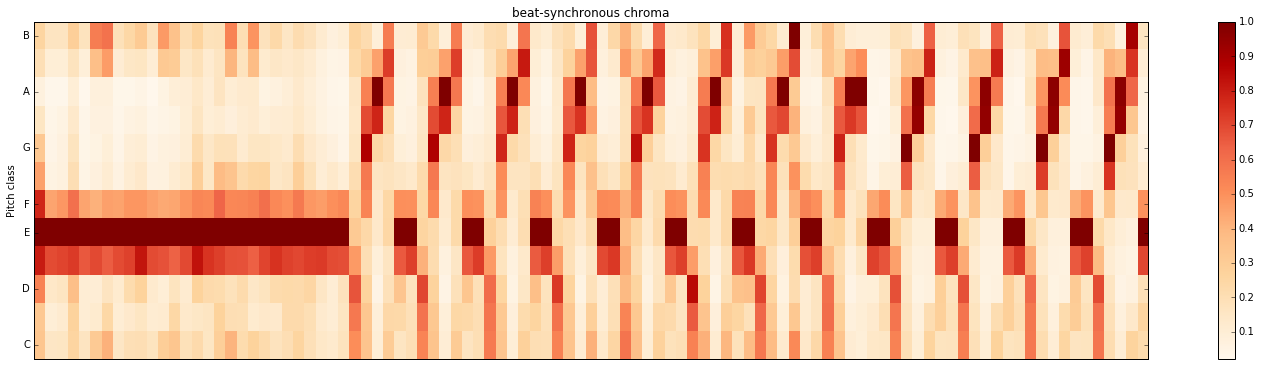

In [40]:
plt.figure(figsize=(20,10))
plt.subplot(2,1,1)
librosa.display.specshow(beat_chroma, y_axis='chroma')
plt.title('beat-synchronous chroma')
plt.colorbar()
plt.tight_layout()